In [4]:
from comet_ml.api import API
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import entropy
from sympy.ntheory import factorint
from sympy.utilities.iterables import multiset_partitions

comet_api = API(api_key="hRTMB66l59BMb9pPrRzLrbzwp")
experiments = comet_api.get(workspace="tensorized-rnn", project_name="speaker-verification")

def fetch_val_eer(experiments, cores_result_dict):
    for exp in experiments:
        tags = exp.get_tags()
        tag = tags[-1]
        
        if tag in cores_result_dict.keys():
            # best validation eer is the last one recorded.
            best_val_eer_dict = exp.get_metrics("best_eer")[-1]
            best_val_eer = float(best_val_eer_dict['metricValue'])
            # best_val_eer_step = int(best_val_eer_dict['step'])
            
            cores_result_dict[tag].append(best_val_eer)
    print(cores_result_dict)
    
    # average results of experiment repeats.
    cores_avg_result_dict = {}
    for tag, eer_list in cores_result_dict.items():
        print("Tag: {}. No of experiments: {}".format(tag, len(eer_list)))
        cores_avg_result_dict[tag] = round(np.mean(eer_list) * 100, 2) 
        
    return cores_avg_result_dict


def safely_get_parameter(api_exp, param_name):
    param_list = api_exp.get_parameters_summary(param_name)
    if len(param_list) == 0:
        raise ValueError("parameter '{}' was not found in experiment '{}'"
                         .format(param_name, api_exp.get_metadata()["experimentKey"]))
    return param_list["valueCurrent"]

###----------FUNCTIONS from t3nsor library for getting auto shape of a tensor-train cores--------####
def _get_all_factors(n, d=3, mode='ascending'):
    p = _factorint2(n)
    if len(p) < d:
        p = p + [1, ] * (d - len(p))

    if mode == 'ascending':
        def prepr(x):
            return tuple(sorted([np.prod(_) for _ in x]))
    elif mode == 'descending':
        def prepr(x):
            return tuple(sorted([np.prod(_) for _ in x], reverse=True))

    elif mode == 'mixed':
        def prepr(x):
            x = sorted(np.prod(_) for _ in x)
            N = len(x)
            xf, xl = x[:N//2], x[N//2:]
            return tuple(_roundrobin(xf, xl))

    else:
        raise ValueError('Wrong mode specified, only {} are available'.format(MODES))

    raw_factors = multiset_partitions(p, d)
    clean_factors = [prepr(f) for f in raw_factors]
    clean_factors = list(set(clean_factors))
    return clean_factors

def _to_list(p):
    res = []
    for k, v in p.items():
        res += [k, ] * v
    return res

def _factorint2(p):
    return _to_list(factorint(p))

def auto_shape(n, d=3, criterion='entropy', mode='ascending'):
    factors = _get_all_factors(n, d=d, mode=mode)
    if criterion == 'entropy':
        weights = [entropy(f) for f in factors]
    elif criterion == 'var':
        weights = [-np.var(f) for f in factors]
    else:
        raise ValueError('Wrong criterion specified, only {} are available'.format(CRITERIONS))

    i = np.argmax(weights)
    return list(factors[i])
###----------FUNCTIONS from t3nsor library for getting auto shape of a tensor-train cores--------####

def lstm_num_params(num_layers, hidden_size, input_size, bias=True):
    n_gates_and_cell = 4
    result = 0
    
    # layer 1
    result = 4 * ((input_size + hidden_size + int(bias)) * hidden_size)
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * 4 * ((hidden_size + hidden_size + int(bias)) * hidden_size)
    
    return result

def tt_linear_num_params(in_size, out_size, n_cores, rank, bias=True):
#     print('in: {}, out: {}, rank: {}, cores: {}'.format(in_size, out_size, rank, n_cores))
    in_core_shape = auto_shape(in_size, n_cores)
    out_core_shape = auto_shape(out_size, n_cores)
    
    # number of parameters in a tt linear layer.
    assert len(in_core_shape) == len(out_core_shape)
    n_cores = len(in_core_shape)
    
    result = 0
    out_size = 1
    for i in range(n_cores):
        if i == 0 or i == n_cores - 1:
            result += rank * (in_core_shape[i]) * out_core_shape[i]
        else:
            result += rank**2 * (in_core_shape[i]) * out_core_shape[i]
        out_size *= out_core_shape[i]
    
    if bias:
        result += out_size
    
#     print('linear output ', result)
    return result

def tt_lstm_num_params_with_concattrick(num_layers, in_size, hidden_size, n_cores, rank, bias=True):
    # number of parameters in a tt lstm that uses concatenation trick.
    n_gates_and_cell = 4
    result = 0
    
    # layer 1
    result = (tt_linear_num_params(in_size, hidden_size * 4, n_cores, rank, False) 
                      + tt_linear_num_params(hidden_size, hidden_size * 4, n_cores, rank, bias))
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * (tt_linear_num_params(hidden_size, hidden_size * 4, n_cores, rank, False) 
                      + tt_linear_num_params(hidden_size, hidden_size * 4, n_cores, rank, bias))
    
    return result

# Model size and parameters

In [3]:
hidden_sizes = [256, 512, 768]
num_layers = [1, 2, 3]
input_size = 40
emb_size = 256

data = []
for hidden_size in hidden_sizes:
    row = []
    for layer_size in num_layers:
        num_linear_layer = ((hidden_size + 1) * emb_size)
        num_lstm_layers = lstm_num_params(layer_size, hidden_size, input_size)
        row.append(num_lstm_layers + num_linear_layer)
    data.append(row)
result = pd.DataFrame(data, index=hidden_sizes, columns=num_layers)
print("No of parameters")
print(result)

No of parameters
           1        2         3
256   369920   895232   1420544
512  1263872  3363072   5462272
768  2682112  7403776  12125440


## Evaluating no of parameters in TT-LSTM

In [11]:
input_size = 40
emb_size = 256
n_cores_list = [2,3,4]
ranks_list = [1, 2, 3, 4, 5]

def print_tt_lstm_options(num_layers, hidden_size, input_size, emb_size, n_cores_list, ranks_list):
    data = []
    for i in range(len(n_cores_list)):
        n_cores = n_cores_list[i]
        row = []
        for rank in ranks_list:
            num_lstm_layers = tt_lstm_num_params_with_concattrick(num_layers, input_size, hidden_size, n_cores, rank, bias=True)
            num_linear_layer = tt_linear_num_params(hidden_size, emb_size, n_cores, rank, bias=True)
            row.append(num_lstm_layers + num_linear_layer)
        data.append(row)
    data = pd.DataFrame(data, index=n_cores_list, columns=ranks_list)
    return data

#---------------
hidden_size = 768
num_layers = 1
print("No of parameters ({}/{})".format(num_layers, hidden_size))
print(print_tt_lstm_options(num_layers, hidden_size, input_size, emb_size, n_cores_list, ranks_list))
print("")

#---------------
hidden_size = 256
num_layers = 3
print("No of parameters ({}/{})".format(num_layers, hidden_size))
print(print_tt_lstm_options(num_layers, hidden_size, input_size, emb_size, n_cores_list, ranks_list))
print("")

#---------------
hidden_size = 512
num_layers = 2
print("No of parameters ({}/{})".format(num_layers, hidden_size))
print(print_tt_lstm_options(num_layers, hidden_size, input_size, emb_size, n_cores_list, ranks_list))
print("")

input_size = 512
emb_size = 0
hidden_size = 512
num_layers = 3
print("No of parameters ({}/{})".format(num_layers, hidden_size))
print(print_tt_lstm_options(num_layers, hidden_size, input_size, emb_size, n_cores_list, ranks_list))
print("")

No of parameters (1/768)
      1      2      3      4      5
2  8176  13024  17872  22720  27568
3  4104   5392   7192   9504  12328
4  3668   4312   5260   6512   8068

No of parameters (3/256)
      1      2      3      4      5
2  9376  15424  21472  27520  33568
3  4720   6944  10000  13888  18608
4  3944   5152   6952   9344  12328

No of parameters (2/512)
       1      2      3      4      5
2  13472  22592  31712  40832  49952
3   5632   7936  11264  15616  20992
4   4944   6048   7664   9792  12432

No of parameters (3/512)
       1      2      3      4      5
2  21536  36928  52320  67712  83104
3   8080  11568  16608  23200  31344
4   7024   8688  11136  14368  18384



# Evaluating no of parameters in linear layer using low-rank factorisation.

In [41]:
def low_rank_params(in_features, out_features, rank, bias):
    return ((in_features + int(bias)) * rank) + ((rank + int(bias)) * out_features)

in_size = 256
out_size = 256
ranks = 2 ** np.arange(1,7)

print("No of parameters (uncompressed):", 256 * 256)
print("Rank\tNum of Parms")
for rank in ranks:
    print("{}\t{}".format(rank, low_rank_params(in_size, out_size, rank, True)))

No of parameters (uncompressed): 65536
Rank	Num of Parms
2	1282
4	2308
8	4360
16	8464
32	16672
64	33088


# Plot experiment result

In [29]:
# dict with "key: n-cores", "value: dict of (key: rank, value: test_eer)"
# experiments_result_dict = {2: {1: 0, 2: 0, 4: 0},
#                           3: {1: 0, 2: 0, 4: 0},
#                           4: {1: 0, 2: 0, 4: 0}}
experiments_result_dict = {2: {1: 0, 2: 0, 3:0, 4: 0},
                          3: {1: 0, 2: 0, 3:0, 4: 0},
                          4: {1: 0, 2: 0, 3:0, 4: 0}}
exp_seed = 11

for exp in experiments:    
    compression = exp.get_parameters_summary("compression")["valueCurrent"]
    if not compression == 'tt' : continue
    
    try:
        n_cores = int(safely_get_parameter(exp, "n_cores"))
        tt_rank = int(safely_get_parameter(exp, "rank"))
        seed = int(safely_get_parameter(exp, "seed"))
        best_val_eer = float(exp.get_metrics("test_EER")[-1]['metricValue'])
    except Exception as e:
        print(e)
        continue

    if n_cores not in experiments_result_dict \
            or tt_rank not in experiments_result_dict[n_cores] \
                or seed != exp_seed:
        print("Skipping experiment: compression={}, n_cores={}, tt_rank={}, seed={}".format(compression, n_cores, tt_rank, seed))
        continue
    experiments_result_dict[n_cores][tt_rank] = best_val_eer
print(experiments_result_dict)
        

Skipping experiment: compression=tt, n_cores=2, tt_rank=5, seed=11
Skipping experiment: compression=tt, n_cores=4, tt_rank=5, seed=11
Skipping experiment: compression=tt, n_cores=3, tt_rank=5, seed=11
{2: {1: 0.047115384616034435, 2: 0.04344512195077787, 3: 0.06874999999999927, 4: 0.06213942307541739}, 3: {1: 0.06093749999999991, 2: 0.053125000000000026, 3: 0.05468749999999987, 4: 0.053846153846863}, 4: {1: 0.05337284482744496, 2: 0.05576923076880846, 3: 0.05312499999999996, 4: 0.04278846153918008}}


TT-2cores params: [8176, 13024, 17872, 22720]
TT-3cores params: [4104, 5392, 7192, 9504]
TT-4cores params: [3668, 4312, 5260, 6512]


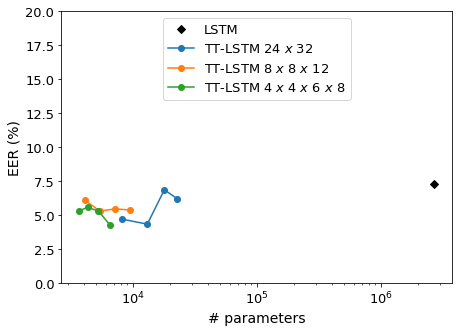

In [45]:
%matplotlib inline

plt.figure(figsize=(7, 5))
input_size = 40
emb_size = 256
hidden_size = 768
num_layers = 1

# plot uncompressed experiment.
plt.plot(2682112, 0.07333 * 100, "D", label="LSTM", color='black', linewidth=3)

# # plot low-rank experiments
# lr_param_counts = [low_rank_params(in_size, out_size, rank, True) for rank in [8, 16, 32, 64]]
# print("LR params: ", lr_param_counts)
# plt.plot(lr_param_counts, [.0647, 0.0587, 0.0433, 0.0511], "-.D", label="low-rank")

# plot tt experiments.
for k, v in experiments_result_dict.items():
    param_counts = []
    for rank in v.keys():
        num_lstm_layers = tt_lstm_num_params_with_concattrick(num_layers, input_size, hidden_size, k, rank, bias=True)
        num_linear_layer = tt_linear_num_params(hidden_size, emb_size, k, rank, bias=True)
    
        param_counts.append(num_lstm_layers + num_linear_layer)
    print("TT-{}cores params: {}".format(k, param_counts))
    
    # plot all rank values for the current core, k.
    shape_str = " $x$ ".join([str(s) for s in auto_shape(hidden_size, k)])
    values_in_perc = [val * 100 for val in v.values()]
    plt.plot(param_counts, values_in_perc, "-o", label="TT-LSTM " + shape_str)
plt.xscale('log')
plt.xlabel('# parameters', fontsize=14)
plt.ylabel('EER (%)', fontsize=14)
plt.ylim([0,20])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13, loc='upper center')
plt.show()

{'tt-cores4-rank2': [0.04134615384757199, 0.04238782051446542, 0.03906250000000022, 0.03906250000009872, 0.039583333334543266], 'tt-cores4-rank3': [0.03914262820514222, 0.04062500000000007], 'tt-cores4-rank4': [0.042187500000000024, 0.044991987178826826, 0.04658830275229364], 'tt-cores4-rank5': [0.04062500000000005, 0.04519230769182035, 0.039022943037974725], 'tt-cores4-rank6': [0.0452681107954545, 0.04311277932960928, 0.03906250000000891], 'tt-cores4-rank8': [0.04687500000000031, 0.0403125, 0.039062499999996725]}
Tag: tt-cores4-rank2. No of experiments: 5
Tag: tt-cores4-rank3. No of experiments: 2
Tag: tt-cores4-rank4. No of experiments: 3
Tag: tt-cores4-rank5. No of experiments: 3
Tag: tt-cores4-rank6. No of experiments: 3
Tag: tt-cores4-rank8. No of experiments: 3


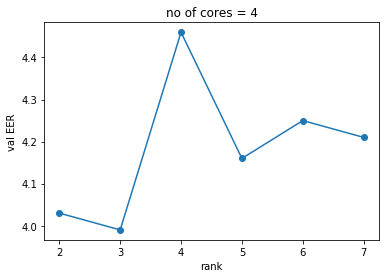

In [78]:
# plot the val EER for each rank.
ranks_result_dict = {'tt-cores4-rank2':[], 'tt-cores4-rank3':[], 'tt-cores4-rank4':[], 'tt-cores4-rank5':[], 
                     'tt-cores4-rank6':[], 'tt-cores4-rank8':[]}
ranks_avg_result_dict = fetch_val_eer(experiments, ranks_result_dict)
plt.figure()
plt.plot(np.arange(2,8), ranks_avg_result_dict.values(), '-o')
plt.xlabel('rank')
plt.ylabel('val EER')
plt.title('no of cores = 4')
plt.show()

# Visualising saved spectograms.

In [3]:
frame_fpath = r'D:\Users\Charley\Documents\Esperanza\repos\_experiments\speech-model-compression\speaker-verification\_librispeech_train-clean-100_tisv\LibriSpeech_train-clean-100_103\1240_103-1240-0000.npy'
frame_fpath = r'D:\Users\Charley\Documents\Esperanza\repos\_experiments\speech-model-compression\speaker-verification\_librispeech_train-clean-100_tisv\LibriSpeech_train-clean-100_1183\128659_1183-128659-0000.npy'
frames = np.load(frame_fpath).transpose()
frames.shape
plt.stem(y)
plt.show()

# import librosa
# import IPython.display as ipd
# wav_path = '777-126732-0006.wav'
# y, sr = librosa.load(wav_path)
# D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
# librosa.display.specshow(D, y_axis='linear')
# plt.colorbar(format='%+2.0f dB')

NameError: name 'y' is not defined

# Visualising UMAP Projections

In [ ]:
def draw_projections(embeds, utterances_per_speaker, step, out_fpath=None,
                     max_speakers=16):
    if self.disabled:
        return
    max_speakers = min(max_speakers, len(colormap))
    embeds = embeds[:max_speakers * utterances_per_speaker]

    n_speakers = len(embeds) // utterances_per_speaker
    ground_truth = np.repeat(np.arange(n_speakers), utterances_per_speaker)
    colors = [colormap[i] for i in ground_truth]

    reducer = umap.UMAP()
    projected = reducer.fit_transform(embeds)
    plt.scatter(projected[:, 0], projected[:, 1], c=colors)
    plt.gca().set_aspect("equal", "datalim")
    plt.title("UMAP projection (step %d)" % step)
    if out_fpath is not None:
        plt.savefig(out_fpath)
    plt.clf()
    self.experiment.log_image(out_fpath, step=step)

colormap = np.array([
    [76, 255, 0],
    [0, 127, 70],
    [255, 0, 0],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [183, 183, 183],
], dtype=np.float) / 255

file_path = "lstm"
with open(file_path, 'r') as fp:
    data = json.load(fp)
model = SpeakerEncoder(pd.mel_n_channels, pm.model_hidden_size, pm.model_num_layers,
                       pm.model_embedding_size, device, loss_device,
                       compression=pm.compression, n_cores=pm.n_cores,
                       rank=pm.rank)
checkpoint = torch.load(state_fpath)
model.load_state_dict(checkpoint["model_state"])
# load model from file.
# run forward pass to get embeds.
# visualise side by side.